In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class FuzzyGasController:
    #todo
    # write all the fuzzify,inference,defuzzify method in this class
    def __init__(self):
        pass

    def decide(self, center_dist,inference_type="Minimum",deffuzify_type = "integral"):
        inp = center_dist
        if center_dist > 200:
            inp = 200
        fuzz = self.fuzzify(inp)
        if inference_type == "Minimum":
            infer = self.inference(fuzz,inference_type=inference_type)
            rot = self.defuzzify(infer,defuzzify_type=deffuzify_type,t_norm_type="min",infer_type="Minimum")
        elif inference_type == "Mamdani":
            infer = self.inference(fuzz,inference_type=inference_type)
            rot = self.defuzzify(infer,defuzzify_type=deffuzify_type,t_norm_type="product")
        elif inference_type == "Luka":
            infer = self.inference(fuzz,inference_type=inference_type)
            rot = self.defuzzify(infer,defuzzify_type=deffuzify_type,infer_type="Luka")
        elif inference_type == "Zadeh":
            infer = self.inference(fuzz,inference_type=inference_type)
            rot = self.defuzzify(infer,defuzzify_type=deffuzify_type,infer_type="Zadeh")
        elif inference_type == "Denis":
            infer = self.inference(fuzz,inference_type=inference_type)
            rot = self.defuzzify(infer,defuzzify_type=deffuzify_type,infer_type="Denis")
        else:
            pass
        return rot
    
    def fuzzify(self,center_dist):
        c = self.d_c(center_dist)
        return c
    
    def inference(self , fuzz , inference_type = "Minimum"):
        lg = fuzz['close_c']
        mg = fuzz['moderate_c']
        hg = fuzz['far_c']
        return {'lg' : lg ,
                'hg' : hg ,
                'mg' : mg}

    def defuzzify(self,infer,defuzzify_type = "integral",t_norm_type = "min" , infer_type = "Minimum"):
        t = np.linspace(0,90,1000)
        if defuzzify_type == "integral":
            num = 0.0
            denum = 0.0
            dt = t[1] - t[0]
            for i in t:
                out = self.output(i)
                u = max(min(out['lg'],infer['lg']),
                        min(out['mg'],infer['mg']),
                        min(out['hg'],infer['hg']))
                if infer_type == "Minimum" or infer_type == "Mamdani":
                    u = max(self.t_norm(out['lg'],infer['lg'],t_norm_type),
                            self.t_norm(out['mg'],infer['mg'],t_norm_type),
                            self.t_norm(out['hg'],infer['hg'],t_norm_type))
                elif infer_type == "Luka":
                    u = min(min(1,1+out['lg']-infer['lg']),
                            min(1,1+out['mg']-infer['mg']),
                            min(1,1+out['hg']-infer['hg']))
                elif infer_type == "Zadeh":
                    u = min(max(min(out['lg'],infer['lg']),1-infer['lg']),
                            max(min(out['mg'],infer['mg']),1-infer['mg']),
                            max(min(out['hg'],infer['hg']),1-infer['hg']))
                elif infer_type == "Denis":
                    u = min(max(1-infer['lg'],out['lg']),
                            max(1-infer['hg'],out['hg']),
                            max(1-infer['mg'],out['mg']))
                else:
                    raise ValueError(f"Unsupported inference type: {infer_type}")
                num += u*i*dt
                denum += u * dt
            return num/denum if denum != 0 else 0
        
        elif defuzzify_type == "average":
            max_lg = 0
            max_hg = 0
            max_mg = 0
            for i in t:
                out = self.output(i)
                if max_lg < min(out['lg'],infer['lg']):
                    max_lg = min(out['lg'],infer['lg'])
                if max_hg < min(out['hg'],infer['hg']):
                    max_hg = min(out['hg'],infer['hg'])
                if max_mg < min(out['mg'],infer['mg']):
                    max_mg = min(out['mg'],infer['mg'])

            first_index_lg = 0 
            last_index_lg = 90
            first_index_mg = 0
            last_index_mg = 90
            first_index_hg = 0
            last_index_hg = 90
            
            for i in t:
                out = self.output(i)
                if min(out['lg'],infer['lg']) == max_lg:
                    if first_index_lg > i:
                        first_index_lg = i
                    if last_index_lg < i:
                        last_index_lg = i
                if min(out['hg'],infer['hg']) == max_hg:
                    if first_index_hg > i:
                        first_index_hg = i
                    if last_index_hg < i:
                        last_index_hg = i
                if min(out['mg'],infer['mg']) == max_mg:
                    if first_index_mg > i:
                        first_index_mg = i
                    if last_index_mg < i:
                        last_index_mg = i
        
            sum=(max_hg+max_lg+max_mg)
            if sum == 0:
                return 0
            max_lg /= sum
            max_hg /= sum
            max_mg /= sum

            return (first_index_hg+last_index_hg)*max_hg/2+(first_index_lg+last_index_lg)*max_lg/2+(first_index_mg+last_index_mg)*max_mg/2

        elif defuzzify_type == "mean_max":
            max_lg = 0
            max_hg = 0
            max_mg = 0

            for i in t:
                out = self.output(i)
                if max_lg < min(out['lg'],infer['lg']):
                    max_lg = min(out['lg'],infer['lg'])
                if max_hg < min(out['hg'],infer['hg']):
                    max_hg = min(out['hg'],infer['hg'])
                if max_mg < min(out['mg'],infer['mg']):
                    max_mg = min(out['mg'],infer['mg'])           
            maximum = max(max_lg,max_hg,max_mg)
            first_index = 90
            last_index = 0
            for i in t:
                out = self.output(i)
                if maximum == max_lg:
                    if min(out['lg'],infer['lg']) == maximum:
                        if first_index > i:
                            first_index = i
                        if last_index < i:
                            last_index = i
                            
                if maximum == max_hg:
                    if min(out['hg'],infer['hg']) == maximum:
                        if first_index > i:
                            first_index = i
                        if last_index < i:
                            last_index = i

                if maximum == max_mg:
                    if min(out['mg'],infer['mg']) == maximum:
                        if first_index > i:
                            first_index = i
                        if last_index < i:
                            last_index = i

            return (last_index + first_index)/2

    class triangle:
        def __init__(self,first,mid,last):
            self.first = first
            self.mid = mid
            self.last = last

        
        def calc(self,input):
            if input < self.first:
                return 0
            elif input == self.mid:
                return 1
            elif input < self.mid:
                return (input - self.first)*(1/(self.mid-self.first))
            elif input < self.last:
                return (self.last - input)*(1/(self.last-self.mid))
            else:
                return 0
    
    def d_c(self,input):
        # for distance from center
        self.close_c = self.triangle(0,0,50)
        self.moderate_c = self.triangle(40,50,100)
        self.far_c = self.triangle(90,200,200)

        x = self.close_c.calc(input)
        y = self.moderate_c.calc(input)
        z = self.far_c.calc(input)

        return {"close_c" : x , "moderate_c" : y , "far_c" : z}
    

    def output(self,input):
        self.low_gas = self.triangle(0,5,10)
        self.medium_gas = self.triangle(0,15,30)
        self.high_gas = self.triangle(25,30,90)
        return {'hg':self.high_gas.calc(input),
                'lg':self.low_gas.calc(input),
                'mg':self.medium_gas.calc(input),
                }
    
    def t_norm(self,a, b, t_norm_type='min'):
        if t_norm_type == 'min':
            return min(a, b)
        elif t_norm_type == 'product':
            return a * b
        else:
            raise ValueError(f"Unsupported t-norm type: {t_norm_type}")
        
    def s_norm(self,a, b, s_norm_type='max'):
        if s_norm_type == 'max':
            return max(a, b)
        else:
            raise ValueError(f"Unsupported s-norm type: {s_norm_type}")
        

In [3]:
fuzz = FuzzyGasController()

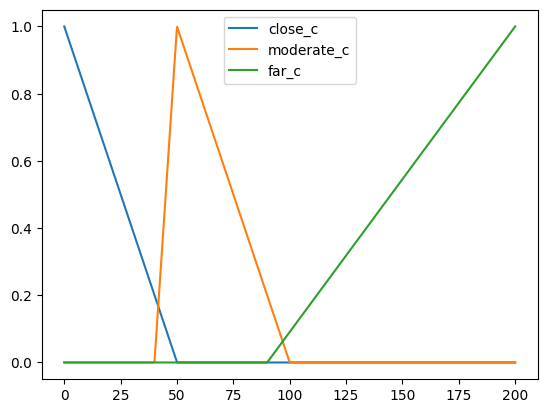

In [4]:
close_c = []
moderate_c = []
far_c = []
t = np.linspace(0,200,1000)
for i in t:
    u = fuzz.fuzzify(i)
    close_c.append(u['close_c'])
    moderate_c.append(u['moderate_c'])
    far_c.append(u['far_c'])

plt.figure()
plt.plot(t,close_c)
plt.plot(t,moderate_c)
plt.plot(t,far_c)
plt.legend(['close_c','moderate_c','far_c'])

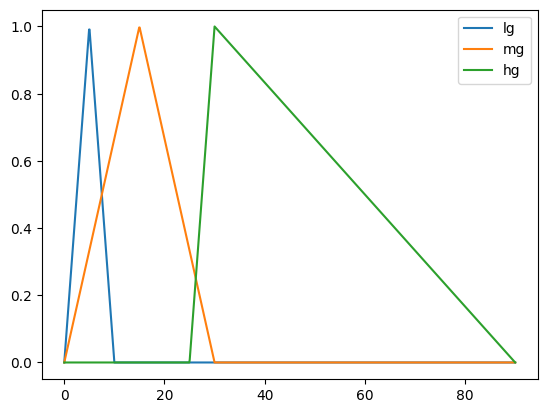

In [5]:
lg = []
mg = []
hg = []
t = np.linspace(0,90,1000)
for i in t:
    u = fuzz.output(i)
    lg.append(u['lg'])
    mg.append(u['mg'])
    hg.append(u['hg'])

plt.figure()
plt.plot(t,lg)
plt.plot(t,mg)
plt.plot(t,hg)
plt.legend(['lg','mg','hg'])

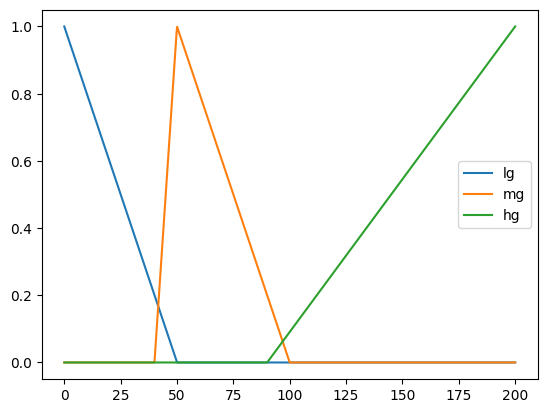

In [6]:
t = np.linspace(0,200,1000)
lg = []
mg = []
hg = []
for i in t:
    u = fuzz.fuzzify(i)
    w = fuzz.inference(u)
    lg.append(w['lg'])
    mg.append(w['mg'])
    hg.append(w['hg'])

plt.figure()
plt.plot(t,lg)
plt.plot(t,mg)
plt.plot(t,hg)
plt.legend(['lg','mg','hg'])